### Task: Build an AI system that recognizes brain tumors on images
Your dataset contains images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. The images are labelled. You will train the Convolutional neural network to predict the classess of brain tumors or detect if there is no brain tumor to support the work of neurologists. For benchmark of your work, you will train random forest model that is expected to work worse than your Convolutional neural network to see how advanced your progress really is.

### Import of necessary Python libraries

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks, optimizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pathlib import Path
import random

### Dowloading dataset
We have images that are: 150 pixels high, 150 pixels width and RGB colors (but all colors are in scale of grey)

In [3]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
data_dir = Path(path) / "Training"

def load_images_50_percent(data_dir):
    class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']
    label_map = {name: idx for idx, name in enumerate(class_names)}

    # Collect all image paths
    all_paths = []
    for class_folder in data_dir.iterdir():
        if class_folder.is_dir() and class_folder.name in label_map:
            for img_path in class_folder.glob("*.jpg"):
                all_paths.append(img_path)

    # Shuffle and select 50%
    random.shuffle(all_paths)
    subset_size = int(len(all_paths) * 0.5)
    selected_paths = all_paths[:subset_size]

    images, labels = [], []

    for img_path in selected_paths:
        class_name = img_path.parent.name
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150, 150)) / 255.0

        images.append(img)
        labels.append(label_map[class_name])

    return np.array(images), np.array(labels), class_names


X_all, y_all, class_names = load_images_50_percent(data_dir)
print(f"Loaded {len(X_all)} images → Classes: {class_names}")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Loaded 2856 images → Classes: ['notumor', 'glioma', 'meningioma', 'pituitary']


### Exemplary picture from our dataset is below - change "3" in X_all[3] and y_all[3] to different number to see other images with the correct labels

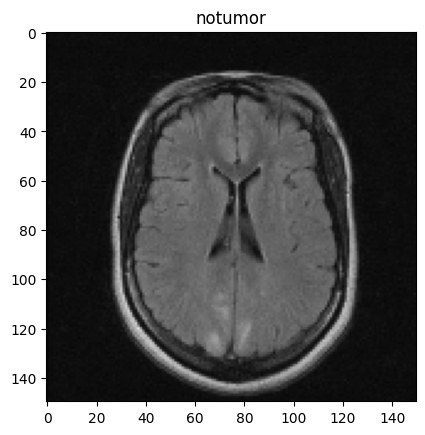

In [4]:
plt.imshow(X_all[3])
plt.title(class_names[y_all[3]])
plt.show()

### Division of dataset into 3 subsets: train, validation, test

In [5]:
# Split: 50% train, 25% validation, 25% test

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=11, stratify=y_all)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=1/3, random_state=11, stratify=y_train_full)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 1428 | Val: 714 | Test: 714


### How random forest and convolutional neural network see the images?
Convolutional neural network (CNN) see the images spatially (structures that create pixels next to each other)

Random forest (RF) see pixels as individual features

It means that we have to prepare our data before processing with models a bit differently for CNN and RF.

### Random forest

In [7]:
# Preparation of data
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

In [8]:
X_train_flat[1].shape

(67500,)

In [9]:
X_train_flat[1]

array([0., 0., 0., ..., 0., 0., 0.])

### Random forest hyperparameters tuning

In [10]:
best_acc = 0
best_params = None

print("\nTuning Random Forest (multi-class)...")
for n_est in [300, 500]:
    for depth in [15, 25, None]:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth,
                                    random_state=42, n_jobs=-1)
        rf.fit(X_train_flat, y_train)
        pred = rf.predict(X_val_flat)
        acc = accuracy_score(y_val, pred)
        print(f"  RF({n_est}, {depth}) → Val Acc: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_params = (n_est, depth)

print(f"\nBest RF → n_estimators={best_params[0]}, max_depth={best_params[1]}, Val Acc = {best_acc:.4f}")


Tuning Random Forest (multi-class)...
  RF(300, 15) → Val Acc: 0.9258
  RF(300, 25) → Val Acc: 0.9188
  RF(300, None) → Val Acc: 0.9188
  RF(500, 15) → Val Acc: 0.9272
  RF(500, 25) → Val Acc: 0.9216
  RF(500, None) → Val Acc: 0.9216

Best RF → n_estimators=500, max_depth=15, Val Acc = 0.9272


### Retraining Random forest with the best set of hyperparameters on train + validation

In [11]:
final_rf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1],
                                  random_state=42, n_jobs=-1)
final_rf.fit(np.vstack([X_train_flat, X_val_flat]),
             np.concatenate([y_train, y_val]))

rf_test_acc = accuracy_score(y_test, final_rf.predict(X_test_flat))

### Convolutional neural network

In [12]:
#Preparation of data - labels to categorical
y_train_cat = to_categorical(y_train, 4)
y_val_cat   = to_categorical(y_val, 4)
y_test_cat  = to_categorical(y_test, 4)

Below is comparison of exemplary image stored in a number form in X_train matrix with no reshaping - you can see the difference between RF and CNN

In [13]:
X_train[1].shape

(150, 150, 3)

In [14]:
X_train[1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

Below we consider Convolutional neural network - just one due to long time of network training

We can see the specific CNN layers: convolution, max pooling, dropout, flatten + droput + activation before output and softmax with 4 classes as output

In [15]:
cnn_model = models.Sequential([

    layers.Input(shape=(150,150,3)),

    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(), layers.Dropout(0.1),

    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),layers.Dropout(0.1),

    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),

    layers.Dense(4, activation='softmax')   # ← 4 classes!
])


### Convolutional neural network training

In [16]:
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[callbacks.EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

best_val_acc = max(history.history['val_accuracy'])
print(f"Best CNN Val Accuracy: {best_val_acc:.4f}")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step - accuracy: 0.4147 - loss: 1.1989 - val_accuracy: 0.6933 - val_loss: 0.8363
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 837ms/step - accuracy: 0.6766 - loss: 0.7655 - val_accuracy: 0.7297 - val_loss: 0.7316
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 690ms/step - accuracy: 0.7522 - loss: 0.6147 - val_accuracy: 0.7493 - val_loss: 0.6251
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 668ms/step - accuracy: 0.8182 - loss: 0.4918 - val_accuracy: 0.7423 - val_loss: 0.5953
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 668ms/step - accuracy: 0.8161 - loss: 0.4566 - val_accuracy: 0.7199 - val_loss: 0.6457
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 662ms/step - accuracy: 0.8702 - loss: 0.3573 - val_accuracy: 0.7633 - val_loss: 0.5463
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - accuracy: 0.8756 - loss: 0.3205 - val_accuracy: 0.8193 - val_loss: 0.4857
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 670ms/step - accuracy: 0.9078 - loss: 0.2623 - 

### Retraining neural network on training + validation dataset with the number of epochs that was the best during training above

In [17]:
final_cnn = models.clone_model(cnn_model)
final_cnn.set_weights(cnn_model.get_weights())
final_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

final_cnn.fit(
    np.concatenate([X_train, X_val]),
    to_categorical(np.concatenate([y_train, y_val]), 4),
    epochs=np.argmax(history.history['val_accuracy']) + 1,
    batch_size=32,
    verbose=0
)

cnn_test_acc = final_cnn.evaluate(X_test, y_test_cat, verbose=0)[1]

### Final comparison of Random forest and Convolutional neural network on test dataset!
### Lets see who has the CNN with the best accuracy on test dataset!

In [18]:
print("\n" + "="*70)
print(" FINAL TEST ACCURACY – 4-CLASS BRAIN TUMOR CLASSIFICATION")
print("="*70)
print(f"{'Model':<20} {'Test Accuracy':<15} {'Winner?'}")
print("-"*70)
print(f"{'Random Forest':<20} {rf_test_acc:.4f}          {'YES' if rf_test_acc > cnn_test_acc else ''}")
print(f"{'CNN':<20} {cnn_test_acc:.4f}          {'YES' if cnn_test_acc > rf_test_acc else ''}")
print("-"*70)
print(f"→ CNN beats RF by {(cnn_test_acc - rf_test_acc)*100:+.2f} percentage points!")
print("="*70)


 FINAL TEST ACCURACY – 4-CLASS BRAIN TUMOR CLASSIFICATION
Model                Test Accuracy   Winner?
----------------------------------------------------------------------
Random Forest        0.9048          
CNN                  0.9216          YES
----------------------------------------------------------------------
→ CNN beats RF by +1.68 percentage points!


### Comparison of confusion matrixes for both RF and CNN on test dataset

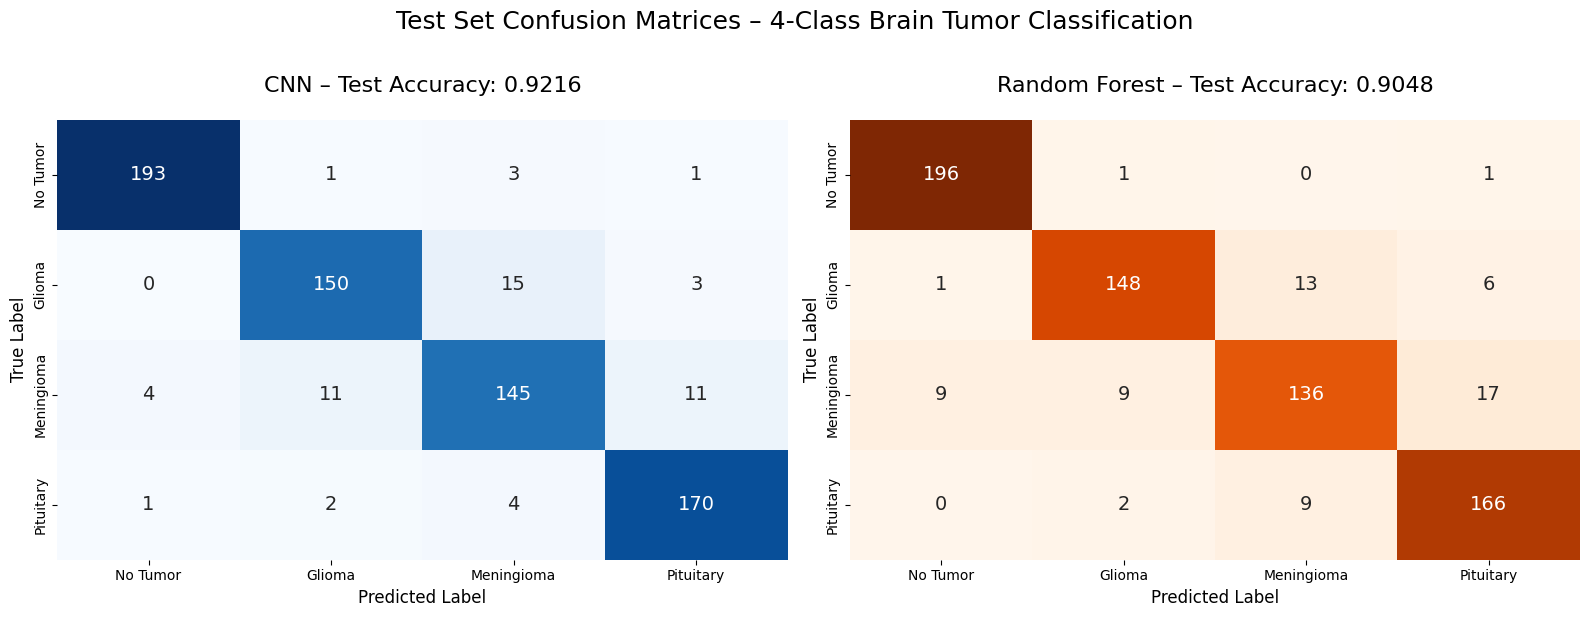

In [19]:
y_pred_cnn = np.argmax(final_cnn.predict(X_test, verbose=0), axis=1)
y_pred_rf  = final_rf.predict(X_test_flat)

# Compute confusion matrices
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

# Plot side-by-side with nice labels
class_names = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN Confusion Matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar=False, annot_kws={"size": 14})
axes[0].set_title(f'CNN – Test Accuracy: {cnn_test_acc:.4f}', fontsize=16, pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar=False, annot_kws={"size": 14})
axes[1].set_title(f'Random Forest – Test Accuracy: {rf_test_acc:.4f}', fontsize=16, pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.suptitle("Test Set Confusion Matrices – 4-Class Brain Tumor Classification",
             fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### Results interpretation
Although the results might be similar (similar accuracy) we are interested the most in cases for which model predicts that there is no tumore and in reality there is a tumor of some kind. These cases are dangerous, because doctor can be misleaded by the model.

Which model has lower nomber of tumors incorrectly classified as "no tumor"?
    
Lets see 3 cases for which RF uncorrectly classified some images as "no tumor" and CNN classified them correctly (if such exist).

Found: 4 cases


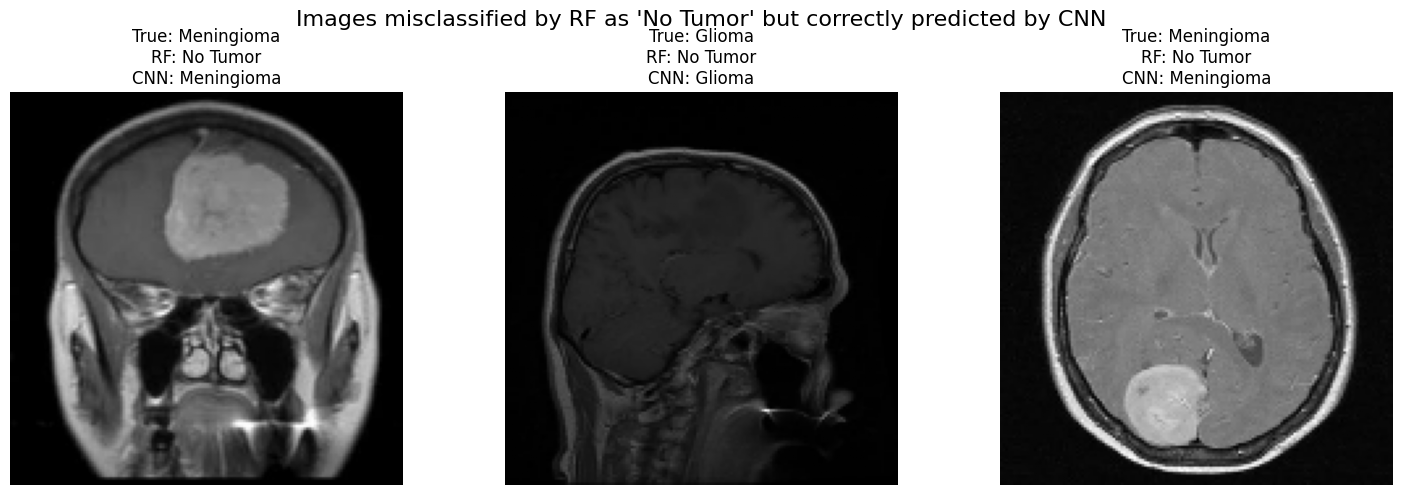

In [20]:
correct_cnn_wrong_rf = np.where(
    (y_pred_cnn == y_test) &        # CNN correct
    (y_pred_rf  != y_test) &        # RF wrong
    (y_pred_rf  == 0)               # RF predicted "No Tumor"
)[0]

print("Found:", len(correct_cnn_wrong_rf), "cases")

# If fewer than 3 exist, adjust automatically
num_to_show = min(3, len(correct_cnn_wrong_rf))
selected_idx = correct_cnn_wrong_rf[:num_to_show]

# --------------------------------------------------
# 3. Display images
# --------------------------------------------------
class_names = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']

plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    true_lbl = class_names[y_test[idx]]
    rf_lbl   = class_names[y_pred_rf[idx]]
    cnn_lbl  = class_names[y_pred_cnn[idx]]

    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(X_test[idx])        # assuming images are scaled to 0–1
    plt.axis('off')

    plt.title(
        f"True: {true_lbl}\nRF: {rf_lbl}\nCNN: {cnn_lbl}",
        fontsize=12
    )

plt.suptitle("Images misclassified by RF as 'No Tumor' but correctly predicted by CNN", fontsize=16)
plt.tight_layout()
plt.show()